# Pruebas

## Definiciones

In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from numpy import load, savez

def getNPZ(name):
    filename = f'./images/processed_images/{name}_01_projected_w.npz'
    return load(filename)['w']

def normalize_vectors(vectors):
    """Normaliza una lista de vectores usando norma L2."""
    original_shape = vectors.shape  # Guardamos la forma original
    vectors = vectors.reshape(vectors.shape[0], -1)  # Aplanamos a (N, D)
    vectors = normalize(vectors, axis=1)  # Normalizamos en la dimensión correcta
    return vectors.reshape(original_shape)  # Restauramos la forma original


## Cargar los datos

In [9]:
def check_npz(df):
    npz_encontrados = []
    npz_no_encontrados = []
    for i, image in df.iterrows():
        name = image['name']
        if not os.path.exists(f'/mnt/discoAmpliado/viky/images/processed_images/{name}_01_projected_w.npz'):
            npz_no_encontrados.append(name)
        else:
            npz_encontrados.append(name)
    if len(npz_no_encontrados) != 0:
        print("NO se encontraron todos los npz")
        return npz_no_encontrados
    else:
        print("SI se encontraron todos los npz")
        return npz_no_encontrados

In [12]:
# Cargar datos
df = pd.read_csv('./dataframe.csv')

print(f'Tamaño total del dataframe: {df.shape}')
npz_no_encontrados = check_npz(df)
#df = df[~df['name'].isin(npz_no_encontrados)] ######## Saco esto por ahora, poque el método que chequea los npz depende de una dirección hardcodeada y no va a funcionar en mi compu personal
df

Tamaño total del dataframe: (2499, 10)
NO se encontraron todos los npz


,gender,id,exp,exp_level,race,attribute,ext,name,raw_image_folder,idUnique
0,F,30,FE,2,BL,F2D,bmp,F0030_FE02BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
1,F,30,AN,2,BL,F2D,bmp,F0030_AN02BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
2,F,30,FE,1,BL,F2D,bmp,F0030_FE01BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
3,F,30,SU,3,BL,F2D,bmp,F0030_SU03BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
4,F,30,DI,1,BL,F2D,bmp,F0030_DI01BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
...,...,...,...,...,...,...,...,...,...,...
2494,M,26,SU,1,AE,F2D,bmp,M0026_SU01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2495,M,26,SA,4,AE,F2D,bmp,M0026_SA04AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2496,M,26,HA,1,AE,F2D,bmp,M0026_HA01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2497,M,26,SA,1,AE,F2D,bmp,M0026_SA01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M


## Primera exploración

In [16]:
def restar_vectores_neutros_y_normalizar(df):
    """Resta el vector neutro de cada persona a sus otras imágenes"""
    adjusted_vectors = []
    
    for person_id, group in df.groupby('idUnique'):
        neutral_vector = None
        
        # Buscar la imagen neutra
        for _, row in group.iterrows():
            if row['exp'] == 'NE':
                neutral_vector = getNPZ(row['name'])
                break
        
        # Si no hay imagen neutra, dejamos los vectores como están
        if neutral_vector is None:
            print(f"Advertencia: No se encontró imagen neutra para {person_id}")
            adjusted_vectors.extend([getNPZ(row['name']) for _, row in group.iterrows()])
            continue
        
        # Restar el vector neutro de las otras imágenes
        for _, row in group.iterrows():
            vector = getNPZ(row['name'])
            adjusted_vectors.append(normalize_vectors(vector - neutral_vector)) #Switch para normalizar o no
            ##adjusted_vectors.append(vector - neutral_vector)
    
    df['adjusted_vector'] = adjusted_vectors
    return df

df = restar_vectores_neutros_y_normalizar(df)

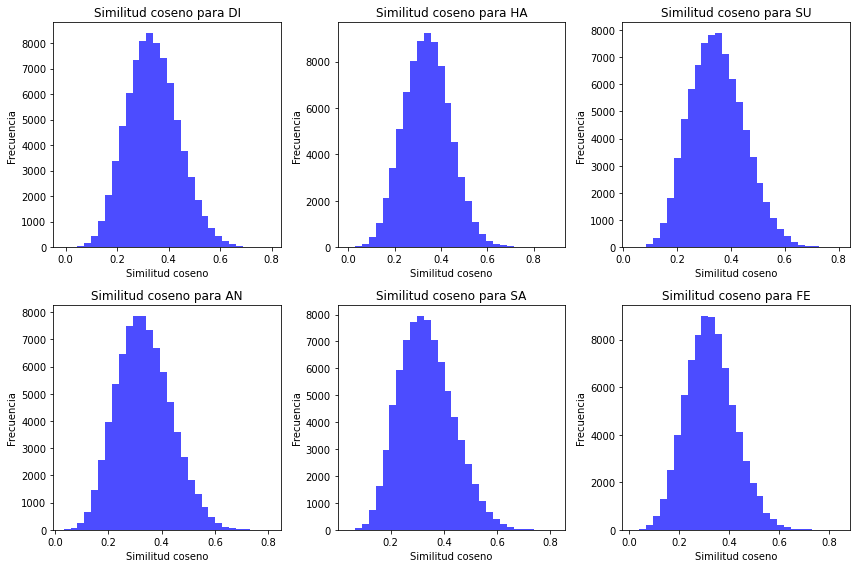

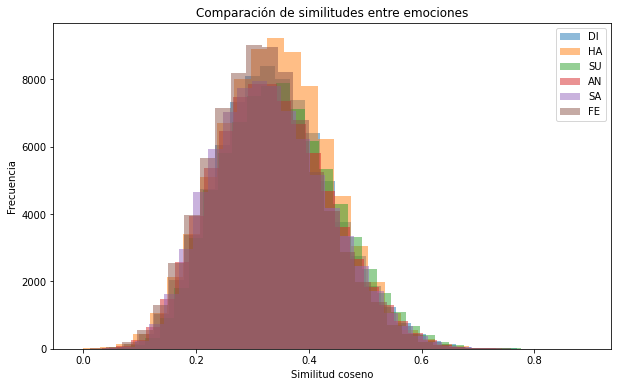

{'DI': array([0.3783348 , 0.41335177, 0.4511793 , ..., 0.47819015, 0.6062414 ,
        0.4208054 ], dtype=float32),
 'HA': array([0.69690585, 0.47282338, 0.650194  , ..., 0.47110546, 0.538054  ,
        0.5066923 ], dtype=float32),
 'SU': array([0.57271737, 0.68028885, 0.5689252 , ..., 0.44580823, 0.4308027 ,
        0.52333057], dtype=float32),
 'AN': array([0.5750616 , 0.47741324, 0.5097215 , ..., 0.44567645, 0.4758227 ,
        0.5228431 ], dtype=float32),
 'SA': array([0.56662345, 0.5838913 , 0.52346087, ..., 0.536475  , 0.50904363,
        0.6292007 ], dtype=float32),
 'FE': array([0.49838704, 0.48163673, 0.5128045 , ..., 0.6230311 , 0.5164858 ,
        0.5590526 ], dtype=float32)}

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


def comparacion_distancias_coseno(df):
    """Calcula distancias coseno entre todos los vectores por emoción y los plottea"""
    df = restar_vectores_neutros_y_normalizar(df)
    results = {}  # Diccionario para guardar los resultados
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    all_distances = []  # Para almacenar todas las distancias y comparar entre emociones
    
    plt.figure(figsize=(12, 8))
    
    for i, emotion in enumerate(emotions):
        subset = df[df['exp'] == emotion]
        ##vectors = np.stack(subset['adjusted_vector'].values)
        vectors = np.array([getNPZ(name) for name in subset['name']])
        
        # Calcular la matriz de similitud coseno
        similarity_matrix = cosine_similarity(vectors.reshape(len(vectors), -1))
        
        # Extraer solo los valores superiores de la matriz (sin la diagonal)
        triu_indices = np.triu_indices_from(similarity_matrix, k=1)
        similarities = similarity_matrix[triu_indices]
        results[emotion] = similarities  # Guardamos las distancias
        all_distances.append(similarities)
        
        # Graficar histograma para esta emoción
        plt.subplot(2, 3, i + 1)
        plt.hist(similarities, bins=30, alpha=0.7, color='b')
        plt.title(f'Similitud coseno para {emotion}')
        plt.xlabel('Similitud coseno')
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    # Comparación entre emociones
    plt.figure(figsize=(10, 6))
    for similarities, emotion in zip(all_distances, emotions):
        plt.hist(similarities, bins=30, alpha=0.5, label=emotion)
    
    plt.xlabel('Similitud coseno')
    plt.ylabel('Frecuencia')
    plt.title('Comparación de similitudes entre emociones')
    plt.legend()
    plt.show()
    
    return results


comparacion_distancias_coseno(df)

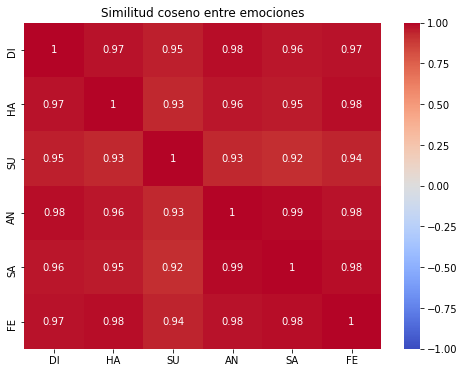

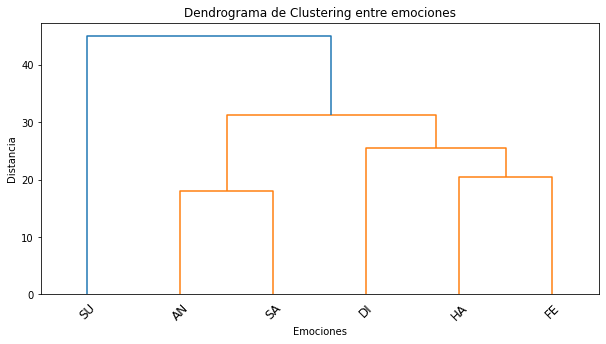

array([[1.0000004 , 0.9715958 , 0.9469331 , 0.9820312 , 0.9629421 ,
        0.9745017 ],
       [0.9715958 , 1.0000001 , 0.9298665 , 0.9632131 , 0.95419216,
        0.9804118 ],
       [0.9469331 , 0.9298665 , 0.9999991 , 0.9332886 , 0.9208815 ,
        0.93962437],
       [0.9820312 , 0.9632131 , 0.9332886 , 1.0000012 , 0.985416  ,
        0.9765293 ],
       [0.9629421 , 0.95419216, 0.9208815 , 0.985416  , 1.0000008 ,
        0.9789884 ],
       [0.9745017 , 0.9804118 , 0.93962437, 0.9765293 , 0.9789884 ,
        0.9999993 ]], dtype=float32)

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram

def comparacion_entre_emociones(df):
    """Calcula la similitud coseno entre emociones diferentes y la visualiza"""
    
    df = restar_vectores_neutros_y_normalizar(df)
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    # Almacenar un vector promedio por emoción
    mean_vectors = {}
    
    for emotion in emotions:
        subset = df[df['exp'] == emotion]
        vectors = np.array([getNPZ(name) for name in subset['name']])
        mean_vectors[emotion] = np.mean(vectors, axis=0)  # Promediamos los vectores
    
    # Crear matriz de similitud coseno entre emociones
    emotion_vectors = np.array([mean_vectors[emotion].flatten() for emotion in emotions])
    similarity_matrix = cosine_similarity(emotion_vectors)
    
    # Visualizar la matriz de similitud coseno como un heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=emotions, yticklabels=emotions, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Similitud coseno entre emociones")
    plt.show()
    
    # Clustering jerárquico para ver relaciones entre emociones
    linkage_matrix = linkage(emotion_vectors, method='ward')  # 'ward' usa distancia euclidiana
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=emotions, leaf_rotation=45, leaf_font_size=12)
    plt.title("Dendrograma de Clustering entre emociones")
    plt.xlabel("Emociones")
    plt.ylabel("Distancia")
    plt.show()
    
    return similarity_matrix

comparacion_entre_emociones(df)

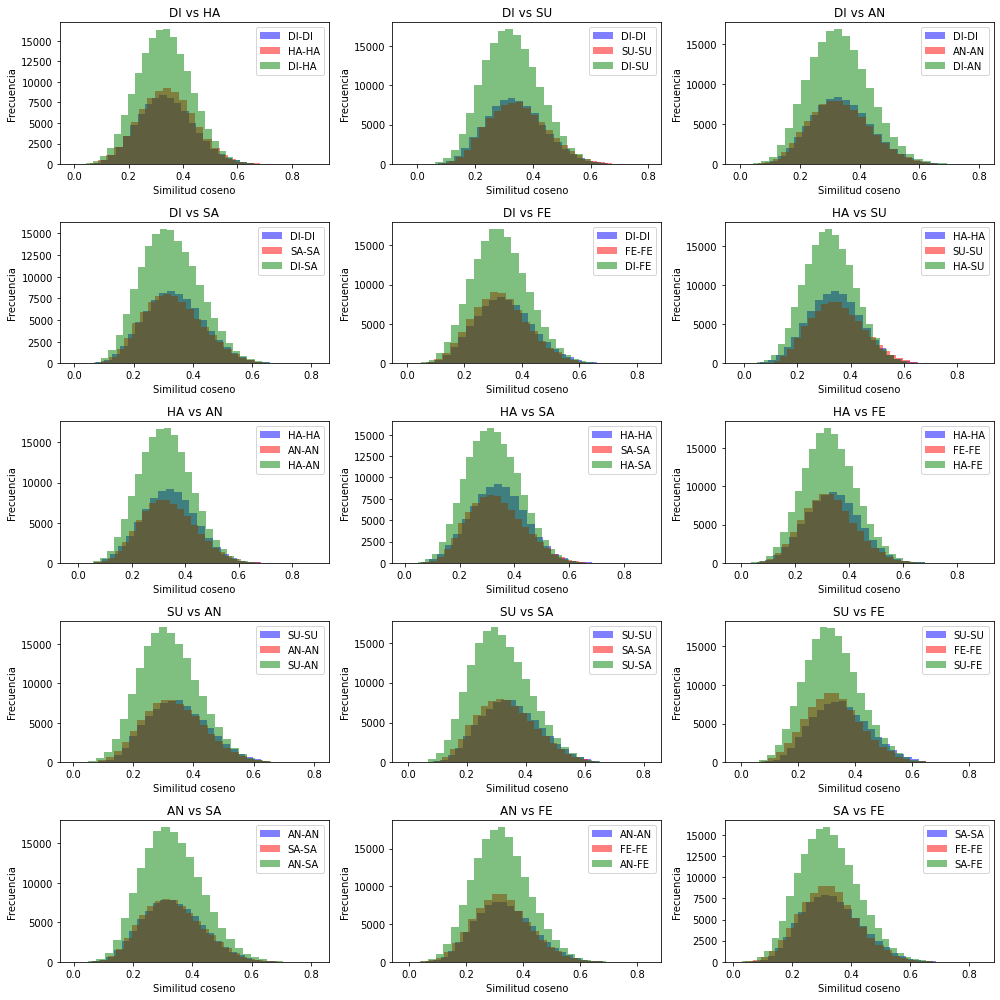

In [19]:
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def comparacion_por_pares(df):
    """Calcula similitud coseno entre pares de emociones y grafica histogramas"""
    
    df = restar_vectores_neutros_y_normalizar(df)
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    plt.figure(figsize=(14, 14))
    
    # Generar todas las combinaciones posibles de pares de emociones
    emotion_pairs = list(itertools.combinations(emotions, 2))
    
    for i, (emotion1, emotion2) in enumerate(emotion_pairs):
        subset1 = df[df['exp'] == emotion1]
        subset2 = df[df['exp'] == emotion2]

        vectors1 = np.array([getNPZ(name) for name in subset1['name']])
        vectors2 = np.array([getNPZ(name) for name in subset2['name']])
        vectors1 = vectors1.reshape(vectors1.shape[0], -1)
        vectors2 = vectors2.reshape(vectors2.shape[0], -1)
        
        # Calcular similitudes dentro de cada emoción (HA-HA, SU-SU)
        sim_matrix1 = cosine_similarity(vectors1)
        sim_matrix2 = cosine_similarity(vectors2)

        # Extraer solo valores únicos (sin la diagonal)
        triu_idx1 = np.triu_indices_from(sim_matrix1, k=1)
        triu_idx2 = np.triu_indices_from(sim_matrix2, k=1)
        similarities1 = sim_matrix1[triu_idx1]
        similarities2 = sim_matrix2[triu_idx2]
        
        # Calcular similitudes entre emociones distintas (HA-SU)
        cross_similarities = cosine_similarity(vectors1, vectors2).flatten()

        # Graficar histograma para este par de emociones
        plt.subplot(5, 3, i + 1)
        plt.hist(similarities1, bins=30, alpha=0.5, label=f'{emotion1}-{emotion1}', color='b')
        plt.hist(similarities2, bins=30, alpha=0.5, label=f'{emotion2}-{emotion2}', color='r')
        plt.hist(cross_similarities, bins=30, alpha=0.5, label=f'{emotion1}-{emotion2}', color='g')
        
        plt.title(f'{emotion1} vs {emotion2}')
        plt.xlabel('Similitud coseno')
        plt.ylabel('Frecuencia')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
comparacion_por_pares(df)

## Método 1: Promedio de promedios

In [20]:
def metodo_1(df):
    """Método 1: Promedio de promedios, por emoción."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset_emocion = df[df['exp'] == emotion]
        promedios_emocion = []
        for idUnique in subset_emocion['idUnique'].unique():
            subset_emocion_persona = subset_emocion[subset_emocion['idUnique'] == idUnique]
            promedio_emocion_persona = np.mean(subset_emocion_persona['adjusted_vector'], axis=0)
            promedios_emocion.append(promedio_emocion_persona)
        promedio_de_promedios_emocion = np.mean(promedios_emocion, axis = 0)
        results[emotion] = promedio_de_promedios_emocion
    return results

metodo_1(df)

{'DI': array([[[-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04],
         [-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04],
         [-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04],
         ...,
         [-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04],
         [-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04],
         [-6.7578680e-05, -1.0205286e-03,  2.2781960e-04, ...,
          -1.5070353e-04,  1.0791451e-03, -5.3269137e-04]]], dtype=float32),
 'HA': array([[[ 0.00010745, -0.0003995 ,  0.00028825, ..., -0.0001874 ,
           0.00192782, -0.00155469],
         [ 0.00010745, -0.0003995 ,  0.00028825, ..., -0.0001874 ,
           0.00192782, -0.00155469],
         [ 0.000

## Método 2: Promedio y luego regresión lineal

In [21]:
def metodo_2(df):
    """Método 2: Promedio y luego regresión lineal, por emoción."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset_emocion = df[df['exp'] == emotion]
        promedios_por_persona = []
        for idUnique in subset_emocion['idUnique'].unique():
            subset_emocion_persona = subset_emocion[subset_emocion['idUnique'] == idUnique]
            promedios_por_persona.append(np.mean(subset_emocion_persona['adjusted_vector'], axis=0))
        if (len(promedios_por_persona) != 100):
            print(f'[ADVERTENCIA] El tamaño del vector de promedios por persona debería ser 100 y es {len(promedios_por_persona)}.')

        
        X = np.arange(len(promedios_por_persona)).reshape(-1, 1) 
        y = np.array(promedios_por_persona).reshape(np.array(promedios_por_persona).shape[0], -1)  # Aplanamos los vectores antes de la regresión

        #print(f'El vector X tiene la forma {X.shape} y el vector y tiene la forma {y.shape}.')
        #print(f'Para la emoción {emotion} el vector X es {X} y el vector y es {y}.')

        
        model = LinearRegression().fit(X, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)  # Restauramos la forma original
            
        ## results[emotion] = promedio_de_promedios_emocion
    return results

metodo_2(df)

{'DI': array([[[ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05],
         [ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05],
         [ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05],
         ...,
         [ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05],
         [ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05],
         [ 2.39322884e-05, -2.71931986e-05,  4.56080878e-05, ...,
          -1.25906569e-05, -3.00744915e-05, -2.05070310e-05]]]),
 'HA': array([[[ 3.78774315e-05, -2.96356600e-06,  8.19718820e-05, ...,
          -2.98469654e-05, -4.24561047e-06, -4.73535594e-06],
         [ 3.78774315e-05, -2.96356600e-06,  8.19718820e-05, ...,
         

## Comparación de Métodos 1 y 2

In [22]:
from scipy.spatial.distance import cosine
import numpy as np

# Función para calcular la similitud coseno entre dos vectores
def cosine_similarity_vectors(v1, v2):
    return 1 - cosine(v1.flatten(), v2.flatten())

# Función para comparar método 1 vs método 2
def compare_results(results1, results2):
    similarities = {}
    for emotion in results1.keys():
        ##print(type(results1[emotion]), results1[emotion].flatten().shape)
        similarities[emotion] = cosine_similarity_vectors(results1[emotion], results2[emotion])
        ##similarities[emotion] = cosine_similarity(results1[emotion].flatten().reshape(1, -1), results2[emotion].flatten().reshape(1, -1))
    return similarities

print(compare_results(metodo_1(df), metodo_2(df)))

{'DI': -0.015101036318919903, 'HA': -0.046714220195570144, 'SU': -0.014232274925754407, 'AN': -0.07049196307984884, 'SA': -0.11361986864433904, 'FE': -0.04737616515717158}


In [23]:
import subprocess

def generate_one_image_from_npz(npz, image_name):

    np.savez(f"images/processed_images/{image_name}_01_projected_w.npz", npz)
    
    npz_path = f"/scratch/images/processed_images/{image_name}_01_projected_w.npz"
    outdir_path = "/scratch/images/generated_images"
    
    command = [
        "/mnt/discoAmpliado/viky/stylegan2-ada-pytorch/docker_run.sh",
        "python",
        "stylegan2-ada-pytorch/generate.py",
        "--network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl",
        f"--outdir={outdir_path}",
        f"--projected-w={npz_path}"
    ]    
    print(f"Ejecutando para la imagen: {image_name}")
    print(f"Comando: {' '.join(command)}")
    subprocess.run(command, check=True)


imagen_modificada_ne = getNPZ(df[df['exp']=='NE']['name'][9])
np.savez(f"images/processed_images/AA_prueba_ne.npz", w=imagen_modificada_ne)

imagen_modificada_ha = getNPZ(df[df['exp']=='NE']['name'][9]) + (metodo_1(df)['HA']*400)
np.savez(f"images/processed_images/AA_prueba_ha.npz", w=imagen_modificada_ha)

imagen_modificada_sa = getNPZ(df[df['exp']=='NE']['name'][9]) + (metodo_1(df)['SA']*400)
np.savez(f"images/processed_images/AA_prueba_sa.npz", w=imagen_modificada_sa)

imagen_modificada_di = getNPZ(df[df['exp']=='NE']['name'][9]) + (metodo_1(df)['DI']*400)
np.savez(f"images/processed_images/AA_prueba_di.npz", w=imagen_modificada_di)
#generate_one_image_from_npz(imagen_modificada, "imagen_de_prueba")

In [24]:
df[df['exp']=='NE']['name'][9]

'F0030_NE00BL_F2D'

In [25]:
imagen_modificada_ha == imagen_modificada_sa

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [26]:

matriz_normalizada = np.array([normalize(arr.reshape(1, -1))[0] for arr in matriz], dtype=object)

print(matriz_normalizada)

NameError: name 'matriz' is not defined

---

# Código legacy

In [ ]:

def method_1_average_then_regression(df):
    """Método 1: Promedia los vectores por emoción y aplica regresión."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset = df[df['exp'] == emotion]
        vectors = np.array([getNPZ(name) for name in subset['name']])
        vectors = normalize_vectors(vectors)
        avg_vector = np.mean(vectors, axis=0) # Podemos hacer promedio de promedios
        
        X = np.arange(len(vectors)).reshape(-1, 1) # por qué no usamos avg_vectors?
        y = vectors.reshape(vectors.shape[0], -1)  # Aplanamos los vectores antes de la regresión

        model = LinearRegression().fit(X, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)  # Restauramos la forma original
    
    return results

def method_2_regression_by_emotion_and_level(df):
    """Método 2: Aplica regresión a cada emoción y nivel de intensidad."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        results[emotion] = {}  # Ahora almacenamos los resultados por nivel
        
        for level in sorted(df['exp_level'].unique()):
            subset = df[(df['exp'] == emotion) & (df['exp_level'] == level)]
            if subset.empty:
                continue
            vectors = np.array([getNPZ(name) for name in subset['name']])
            vectors = normalize_vectors(vectors)
            
            X = np.arange(len(vectors)).reshape(-1, 1)
            y = vectors.reshape(vectors.shape[0], -1)  # Aplanamos los vectores antes de la regresión
            
            model = LinearRegression().fit(X, y)
            results[emotion][level] = model.coef_.reshape(1, 18, 512)  # Guardamos cada nivel separadamente
    
    return results

def method_3_regression_with_level_variable(df): # Este volver a chequear qué hace
    """Método 3: Incluye el nivel como variable numérica en la regresión."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset = df[df['exp'] == emotion]
        vectors = np.array([getNPZ(name) for name in subset['name']])
        vectors = normalize_vectors(vectors)
        levels = subset['exp_level'].values.reshape(-1, 1)

        y = vectors.reshape(vectors.shape[0], -1)
        
        model = LinearRegression().fit(levels, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)
    
    return results

def save_results_as_csv(results, filename):
    flat_results = {}
    
    for key, value in results.items():
        flat_results[key] = value.flatten()  # Aplanar la matriz
    
    df = pd.DataFrame.from_dict(flat_results, orient='index')
    df.to_csv(filename)

    save_results_as_csv(method_1_results, 'method_1_results.csv')


def save_results_as_npz(results, filename):
    """Guarda los resultados en un archivo NPZ."""
    np.savez(filename, **results)

## Ejecutar los 3 métodos y guardar como npz

In [ ]:
method_1_results = method_1_average_then_regression(df)
method_2_results = method_2_regression_by_emotion_and_level(df)
method_3_results = method_3_regression_with_level_variable(df)

print("Imprimo shape de uno de los vectores para controlar formato:")
print("Resultados método 1, 'DI': " + str(method_1_results['DI'].shape))
print("Resultados método 2, 'DI': " + str(method_2_results['DI'][1].shape))
print("Resultados método 3, 'DI': " + str(method_3_results['DI'].shape))

# Guardar resultados
save_results_as_npz(method_1_results, 'method_1_results.npz')
save_results_as_npz(method_2_results, 'method_2_results.npz')
save_results_as_npz(method_3_results, 'method_3_results.npz')

## Printeo la forma de los diccionarios para saber con qué estoy trabajando

In [ ]:
def print_shape(diccionario, indent=0):
    for clave, valor in diccionario.items():
        # Indentación para la estructura
        print("  " * indent + f"Clave: {clave}", end=' ')
        
        if isinstance(valor, dict):
            # Si el valor es otro diccionario, lo recorremos recursivamente
            print("; Valor: Diccionario con las siguientes claves: ")
            print_shape(valor, indent + 1)
        elif isinstance(valor, np.ndarray):
            # Si el valor es un array de NumPy, mostramos su forma
            print(f"; Valor: Array de la forma {valor.shape}")
        elif isinstance(valor, list):
            # Si el valor es una lista, mostramos su longitud
            print(f"(Lista) - Shape: {len(valor)}")
        else:
            # Si no es ni diccionario, ni array ni lista, solo mostramos el tipo
            print(f"({type(valor).__name__})")

print("Forma del diccionario correspondiente al método 1: ")
print_shape(method_1_results)
print("Fin del diccionario correspondiente al método 1.\n")
print("Forma del diccionario correspondiente al método 2: ")
print_shape(method_2_results)
print("Fin del diccionario correspondiente al método 2.\n")
print("Forma del diccionario correspondiente al método 3: ")
print_shape(method_3_results)
print("Fin del diccionario correspondiente al método 3.\n")

## Intentando analisis de datos

## 1. Similitud coseno

In [ ]:
# Función para comparar método 1 vs método 3
def compare_results(results1, results3):
    similarities = {}
    for emotion in results1.keys():
        similarities[emotion] = cosine_similarity([results1[emotion].flatten(), results3[emotion].flatten()])
    return similarities

In [ ]:
print(compare_results(method_1_results, method_3_results))

In [ ]:
import matplotlib.pyplot as plt

a = [1, 1]
b = [1, 2]
c = [2, 1]
#X = 
#y = 

plt.scatter(a, b)
plt.show()


#model = LinearRegression().fit(X, y)
#results[emotion] = model.coef_.reshape(1, 18, 512)